In [1]:
import ast
import json, pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec as wv

In [2]:
df = pd.read_csv("archive/clean_IMDB3.csv")

In [3]:
tokens = df["clean_review"].apply(ast.literal_eval)
texts = tokens.apply(lambda t: " ".join(t)).tolist()

In [4]:
y = df["sentiment"].map({"negative":0, "positive":1}).astype(int).values

In [5]:
X_train_text, X_test_text, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
max_words = 20000
max_len   = 200
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)

In [7]:
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq  = tokenizer.texts_to_sequences(X_test_text)

In [8]:
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad  = pad_sequences(X_test_seq,  maxlen=max_len)

In [10]:
w2v = wv.load("modelW2V/modelWV6.model")
wv = w2v.wv; vocab = wv.key_to_index
embedding_matrix = np.random.normal(0,0.05,(max_words, wv.vector_size)).astype(np.float32)
for word, idx in tokenizer.word_index.items():
    if idx < max_words and word in vocab:
        embedding_matrix[idx] = wv[word]

In [ ]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=wv.vector_size, input_length=max_len,
              weights=[embedding_matrix], trainable=True),
    Conv1D(128, 5, activation="relu"),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

c:\Users\djibr\miniconda3\envs\terEnv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [12]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 2,000,000 (7.63 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, min_lr=1e-5)
]

In [14]:
history = model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=8,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.8238 - loss: 0.3886 - val_accuracy: 0.8792 - val_loss: 0.2900 - learning_rate: 0.0010
Epoch 2/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.8994 - loss: 0.2530 - val_accuracy: 0.8846 - val_loss: 0.2803 - learning_rate: 0.0010
Epoch 3/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.9311 - loss: 0.1857 - val_accuracy: 0.8857 - val_loss: 0.2861 - learning_rate: 0.0010
Epoch 4/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9610 - loss: 0.1197 - val_accuracy: 0.8852 - val_loss: 0.3013 - learning_rate: 5.0000e-04


In [15]:
loss, acc = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"Accuracy (evaluate): {acc:.4f}")

Accuracy (evaluate): 0.8880


In [16]:
y_prob = model.predict(X_test_pad, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)

In [17]:
print("Accuracy (sklearn):", accuracy_score(y_test, y_pred))
print("F1 (weighted):     ", f1_score(y_test, y_pred, average="weighted"))
print("\nRapport de classification :")
print(classification_report(y_test, y_pred, target_names=["negative","positive"], zero_division=0))

Accuracy (sklearn): 0.888
F1 (weighted):      0.8879727370452875

Rapport de classification :
              precision    recall  f1-score   support

    negative       0.88      0.90      0.89      5000
    positive       0.90      0.87      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



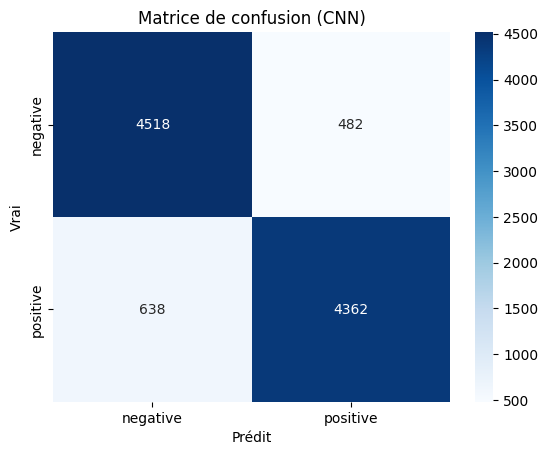

In [18]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["negative","positive"], yticklabels=["negative","positive"])
plt.title("Matrice de confusion (CNN)")
plt.xlabel("Prédit"); plt.ylabel("Vrai")
plt.show()

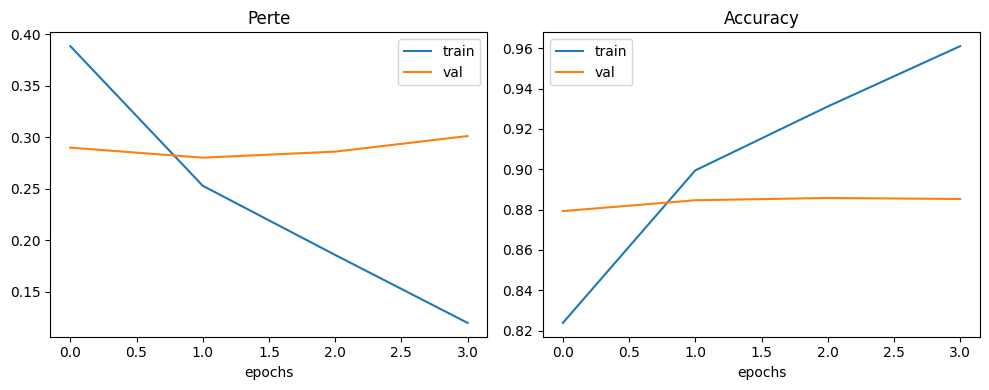

In [19]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history.get("loss", []), label="train")
plt.plot(history.history.get("val_loss", []), label="val")
plt.title("Perte"); plt.xlabel("epochs"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history.get("accuracy", []), label="train")
plt.plot(history.history.get("val_accuracy", []), label="val")
plt.title("Accuracy"); plt.xlabel("epochs"); plt.legend()
plt.tight_layout()
plt.show()

In [20]:
model.save("modelDL/CNN/cnnModelV2.h5")
with open("modelDL/CNN/cnntokenizerV2.pkl","wb") as f:
    pickle.dump(tokenizer, f)
with open("modelDL/CNN/cnnconfigV2.json","w") as f:
    json.dump({"max_len": int(max_len)}, f)
with open("modelDL/CNN/cnnclass_namesV2.json","w") as f:
    json.dump(["negative","positive"], f)
with open("modelDL/CNN/cnnhistoryV2.json", "w") as f:
    json.dump(history.history, f)

In [ ]:
def predict_one(text):
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=max_len)
    p = float(model.predict(pad, verbose=0).ravel()[0])
    label = "positive" if p >= 0.5 else "negative"
    return label, p

In [22]:
print(predict_one("This movie is awful. Boring and badly acted."))
print(predict_one("I absolutely loved this film! Great story and acting."))

('negative', 0.49086663126945496)
('positive', 0.6661059856414795)
